# Lesson 39: Text vectorization demonstration

This notebook demonstrates key concepts and tools for converting text into numerical vectors.

**1. Sparse representations**
- 1.1. One-hot encoding
- 1.2. Bag-of-Words
- 1.3. TF-IDF

**2. Dense representations**
- 2.1. Word2Vec

**3. Comparison**
- 3.1. Classification accuracy
- 3.2. Visualizing encoding methods with t-SNE



## Notebook set up

### Imports


In [1]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.patches import Patch
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import movie_reviews, stopwords

import nltk
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('movie_reviews', quiet=True)
nltk.download('stopwords', quiet=True)

True

### Load movie reviews corpus

In [2]:
# Load movie reviews dataset
documents = [(movie_reviews.raw(fileid), category)
             for category in movie_reviews.categories()
             for fileid in movie_reviews.fileids(category)]

all_texts = [doc[0] for doc in documents]
all_labels = [doc[1] for doc in documents]

print(f'Total reviews: {len(all_texts)}')
print(f'Categories: {set(all_labels)}')

Total reviews: 2000
Categories: {'pos', 'neg'}


### Sample corpus for demonstrations

Select a few sample reviews for encoding demonstrations.

In [ ]:
# Select 5 sample reviews for demonstration and clean up whitespace
corpus = [' '.join(review.split()) for review in all_texts[:5]]

# Tokenize and remove stop words
stop_words = set(stopwords.words('english'))

tokenized_corpus = [
    [w for w in word_tokenize(review.lower()) if w.isalpha() and w not in stop_words]
    for review in corpus
]

print('Sample reviews from movie reviews dataset:')
print()

for i, review in enumerate(corpus):
    print(f'Review {i+1}: {review[:80]}...' if len(review) > 80 else f'Review {i+1}: {review}')

Sample reviews from movie reviews dataset:

Review 1: plot : two teen couples go to a church party , drink and then drive . they get i...
Review 2: the happy bastard's quick movie review damn that y2k bug . it's got a head start...
Review 3: it is movies like these that make a jaded movie viewer thankful for the inventio...
Review 4: " quest for camelot " is warner bros . ' first feature-length , fully-animated a...
Review 5: synopsis : a mentally unstable man undergoing psychotherapy saves a boy from a p...


## 1. Sparse representations

### 1.1. One-hot encoding

One-hot encoding represents each word as a sparse binary vector where only one element is 1 and all others are 0.

In [4]:
# Build vocabulary
all_words = set()

for sentence in tokenized_corpus:
    all_words.update(sentence)

vocab = sorted(list(all_words))
word_to_idx = {word: idx for idx, word in enumerate(vocab)}

print(f'Vocabulary size: {len(vocab)}')
print(f'Vocabulary: {", ".join(vocab[:50])}...')

Vocabulary size: 867
Vocabulary: able, accident, accidentally, across, acting, action, actor, actors, actually, adequate, ads, adults, adventures, affair, ago, allowing, already, also, although, always, american, anastasia, angry, animation, another, answers, anything, apart, apparent, apparently, apparitions, appears, applaud, arguing, around, arrival, arrow, arthur, aside, assuming, attempt, attempting, audience, average, avoid, away, awful, awfully, back, bad...


In [ ]:
# One-hot encode a document (binary presence of each word)
def one_hot_encode_document(tokens, vocab_size, word_to_idx):

    vector = np.zeros(vocab_size)

    for word in tokens:
        if word in word_to_idx:
            vector[word_to_idx[word]] = 1

    return vector

# Show one-hot encoding for corpus reviews
onehot_df = pd.DataFrame(
    [one_hot_encode_document(tokens, len(vocab), word_to_idx) for tokens in tokenized_corpus],
    index=[f'Review {i+1}' for i in range(len(corpus))],
    columns=vocab
).astype(int)

print('Sample sentences (truncated for display):')

for i, review in enumerate(corpus):
    display_text = review[:60] + '...' if len(review) > 60 else review
    print(f'  Review {i+1}: {display_text}')

print('\nOne-hot encoding (binary word presence per review):')
print('(Showing first 15 features only)\n')
onehot_df.iloc[:, :15]

Sample sentences (truncated for display):
  Review 1: plot : two teen couples go to a church party , drink and the...
  Review 2: the happy bastard's quick movie review damn that y2k bug . i...
  Review 3: it is movies like these that make a jaded movie viewer thank...
  Review 4: " quest for camelot " is warner bros . ' first feature-lengt...
  Review 5: synopsis : a mentally unstable man undergoing psychotherapy ...

One-hot encoding (binary word presence per review):
(Showing first 15 features only)



,able,accident,accidentally,across,acting,action,actor,actors,actually,adequate,ads,adults,adventures,affair,ago
Review 1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1
Review 2,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0
Review 3,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
Review 4,1,0,1,0,0,0,0,1,0,0,0,1,1,0,0
Review 5,0,1,0,0,0,0,1,0,1,1,0,0,0,1,0


### 1.2. Bag-of-Words

Bag-of-Words represents each document as a vector of word counts, ignoring word order.

Scikit-learn [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) documentation

In [ ]:
# Create Bag-of-Words representation
bow_vectorizer = CountVectorizer(stop_words='english')
bow_matrix = bow_vectorizer.fit_transform(corpus)

# Display as dataframe
bow_df = pd.DataFrame(
    bow_matrix.toarray(),
    columns=bow_vectorizer.get_feature_names_out(),
    index=[f'Review {i+1}' for i in range(len(corpus))]
)

print('Sample reviews (truncated for display):')

for i, review in enumerate(corpus):
    display_text = review[:60] + '...' if len(review) > 60 else review
    print(f'  Review {i+1}: {display_text}')

print('\nBag-of-Words (word counts per review):')
print('(Showing first 15 features only)\n')
bow_df.iloc[:, :15]

Sample reviews (truncated for display):
  Review 1: plot : two teen couples go to a church party , drink and the...
  Review 2: the happy bastard's quick movie review damn that y2k bug . i...
  Review 3: it is movies like these that make a jaded movie viewer thank...
  Review 4: " quest for camelot " is warner bros . ' first feature-lengt...
  Review 5: synopsis : a mentally unstable man undergoing psychotherapy ...

Bag-of-Words (word counts per review):
(Showing first 15 features only)



,10,1960,1990s,1997,20,20th,90s,able,abo,accident,accidentally,acting,action,actor,actors
Review 1,10,0,0,0,1,0,0,0,0,1,0,0,0,0,1
Review 2,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0
Review 3,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0
Review 4,0,0,0,1,0,1,1,1,0,0,1,0,0,0,1
Review 5,0,0,1,0,0,0,0,0,2,1,0,0,0,2,0


### 1.3. TF-IDF

TF-IDF (Term Frequency-Inverse Document Frequency) weights words by their importance, giving lower weight to common words.

Scikit-learn [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) documentation

In [ ]:
# Create TF-IDF representation
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)

# Display as dataframe
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray().round(3),
    columns=tfidf_vectorizer.get_feature_names_out(),
    index=[f'Review {i+1}' for i in range(len(corpus))]
)

print('Sample reviews (truncated for display):')

for i, review in enumerate(corpus):
    display_text = review[:60] + '...' if len(review) > 60 else review
    print(f'  Review {i+1}: {display_text}')

print('\nTF-IDF (weighted word importance per review):')
print('(Showing first 15 features only)\n')
tfidf_df.iloc[:, :15]

Sample reviews (truncated for display):
  Review 1: plot : two teen couples go to a church party , drink and the...
  Review 2: the happy bastard's quick movie review damn that y2k bug . i...
  Review 3: it is movies like these that make a jaded movie viewer thank...
  Review 4: " quest for camelot " is warner bros . ' first feature-lengt...
  Review 5: synopsis : a mentally unstable man undergoing psychotherapy ...

TF-IDF (weighted word importance per review):
(Showing first 15 features only)



,10,1960,1990s,1997,20,20th,90s,able,abo,accident,accidentally,acting,action,actor,actors
Review 1,0.467,0.000,0.000,0.000,0.047,0.000,0.000,0.000,0.000,0.038,0.000,0.000,0.000,0.000,0.038
Review 2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.138,0.085,0.000,0.000
Review 3,0.000,0.122,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.049,0.000,0.000,0.000
Review 4,0.000,0.000,0.000,0.057,0.000,0.057,0.057,0.057,0.000,0.000,0.057,0.000,0.000,0.000,0.046
Review 5,0.000,0.000,0.039,0.000,0.000,0.000,0.000,0.000,0.078,0.032,0.000,0.000,0.000,0.078,0.000


## 2. Dense representations

### 2.1. Word2Vec

Word2Vec learns dense vector representations where semantically similar words have similar vectors.

Gensim [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html) documentation

Let's train Word2Vec on the full movie reviews corpus to capture rich semantic relationships.

#### 2.1.1. Train Word2Vec model

In [8]:
# Tokenize all movie reviews for Word2Vec training
all_tokens = [word_tokenize(text.lower()) for text in all_texts]

print(f'Training Word2Vec on {len(all_tokens)} movie reviews...')

# Train Word2Vec model
w2v_model = Word2Vec(
    sentences=all_tokens,        # List of tokenized documents
    vector_size=500,             # Dimensionality of word vectors
    window=5,                    # Context window size (words before/after target)
    min_count=5,                 # Minimum word frequency to include in vocabulary
    seed=315                     # Random seed for reproducibility
)

print(f'Vocabulary size: {len(w2v_model.wv)}')

Training Word2Vec on 2000 movie reviews...
Vocabulary size: 14878


#### 2.1.2. Examining word vectors

Let's look at the actual vector representations for some words.

In [10]:
# Show word vectors for sample words
sample_words = ['loved', 'boring', 'movie']

w2v_df = pd.DataFrame(
    [w2v_model.wv[w][:10] for w in sample_words if w in w2v_model.wv],
    index=[w for w in sample_words if w in w2v_model.wv],
    columns=[f'dim_{i}' for i in range(10)]
).round(3)

print(f'Word2Vec vector size: {w2v_model.wv.vector_size}')
print('Word vectors (dense, continuous values, showing first 10 dimensions):\n')
w2v_df

Word2Vec vector size: 500
Word vectors (dense, continuous values, showing first 10 dimensions):



,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9
loved,-0.020,0.047,-0.112,0.190,-0.076,-0.005,0.174,0.163,-0.044,0.180
boring,-0.043,0.119,0.062,0.125,0.078,-0.329,0.133,-0.047,-0.146,-0.189
movie,-0.085,-0.323,-0.686,-0.358,0.314,-0.167,0.575,-0.928,-0.010,-0.836


## 3. Comparison

### 3.1. Classification accuracy

Let's compare how well each encoding method performs on a simple sentiment classification task using logistic regression. This demonstrates that while Word2Vec has semantic advantages, simpler count-based methods can still be very effective for labeled classification tasks.

In [11]:
# Prepare data for classification
X_train, X_test, y_train, y_test = train_test_split(
    all_texts, all_labels, test_size=0.2, random_state=315
)

#### 3.1.1. One-hot encoding

In [12]:
# One-hot encoding
onehot_vec = CountVectorizer(binary=True, max_features=500)
X_train_onehot = onehot_vec.fit_transform(X_train)
X_test_onehot = onehot_vec.transform(X_test)

lr_onehot = LogisticRegression(max_iter=1000, random_state=315)
lr_onehot.fit(X_train_onehot, y_train)
acc_onehot = accuracy_score(y_test, lr_onehot.predict(X_test_onehot))

print(f'One-hot accuracy: {acc_onehot:.4f}')

One-hot accuracy: 0.7575


#### 3.1.2. Bag-of-Words

In [13]:
# Bag-of-Words
bow_vec = CountVectorizer(max_features=500)
X_train_bow = bow_vec.fit_transform(X_train)
X_test_bow = bow_vec.transform(X_test)

lr_bow = LogisticRegression(max_iter=1000, random_state=315)
lr_bow.fit(X_train_bow, y_train)
acc_bow = accuracy_score(y_test, lr_bow.predict(X_test_bow))

print(f'Bag-of-Words accuracy: {acc_bow:.4f}')

Bag-of-Words accuracy: 0.7450


#### 3.1.3. TF-IDF

In [14]:
# TF-IDF
tfidf_vec = TfidfVectorizer(max_features=500)
X_train_tfidf = tfidf_vec.fit_transform(X_train)
X_test_tfidf = tfidf_vec.transform(X_test)

lr_tfidf = LogisticRegression(max_iter=1000, random_state=315)
lr_tfidf.fit(X_train_tfidf, y_train)
acc_tfidf = accuracy_score(y_test, lr_tfidf.predict(X_test_tfidf))

print(f'TF-IDF accuracy: {acc_tfidf:.4f}')

TF-IDF accuracy: 0.7700


#### 3.1.4. Word2Vec

In [15]:
# Word2Vec (average word vectors per document)
def get_doc_vector(text, model):

    tokens = [w for w in word_tokenize(text.lower()) if w.isalpha()]
    vectors = [model.wv[w] for w in tokens if w in model.wv]

    if vectors:
        return np.mean(vectors, axis=0)

    return np.zeros(model.wv.vector_size)

X_train_w2v = np.array([get_doc_vector(text, w2v_model) for text in X_train])
X_test_w2v = np.array([get_doc_vector(text, w2v_model) for text in X_test])

lr_w2v = LogisticRegression(max_iter=1000, random_state=315)
lr_w2v.fit(X_train_w2v, y_train)
acc_w2v = accuracy_score(y_test, lr_w2v.predict(X_test_w2v))

print(f'Word2Vec accuracy: {acc_w2v:.4f}')

Word2Vec accuracy: 0.6675


#### 3.1.5. Results summary

In [16]:
# Display results
results_df = pd.DataFrame({
    'Encoding Method': ['One-hot', 'Bag-of-Words', 'TF-IDF', 'Word2Vec'],
    'Test Accuracy': [acc_onehot, acc_bow, acc_tfidf, acc_w2v]
})

print('Classification accuracy comparison:')
print()
results_df

Classification accuracy comparison:



,Encoding Method,Test Accuracy
0,One-hot,0.7575
1,Bag-of-Words,0.7450
2,TF-IDF,0.7700
3,Word2Vec,0.6675


**Key observations:**

1. **Simple count-based methods work well** for this task. One-hot, BoW, and TF-IDF all achieve strong performance on sentiment classification, demonstrating that frequency patterns are informative for supervised learning with labeled data.

2. **Fair comparison:** All methods use 500 features (max_features=500 for count-based methods, vector_size=500 for Word2Vec), making the comparison equitable in terms of representational capacity.

3. **Word2Vec with averaging** creates document vectors by averaging all word vectors in the document. While this loses information about word importance and frequency, it captures the overall semantic content of the document.

4. **Task matters:** For sentiment classification with abundant labeled data, simpler methods are often sufficient and more interpretable. Word2Vec shines in tasks requiring semantic understanding, transfer learning, or when labeled data is scarce.

### 3.2. Visualizing encoding methods with t-SNE

Let's compare TF-IDF and Word2Vec to see the fundamental difference between sparse, frequency-based encodings and dense, semantically aware encodings.

In [ ]:
# Select interesting words representing different semantic categories
interesting_words = [
    'loved', 'enjoyed', 'brilliant', 'amazing', 'wonderful',
    'boring', 'waste', 'disappointing', 'worst', 'awful',
    'movie', 'film', 'story', 'plot', 'script',
    'actor', 'actress', 'character', 'director'
]

# Filter to words in vocabulary
words = [w for w in interesting_words if w in w2v_model.wv]

# Get Word2Vec embeddings
w2v_vectors = np.array([w2v_model.wv[w] for w in words])

# TF-IDF: Fit on full corpus to get IDF weights, then extract word vectors
tfidf_vectorizer_comp = TfidfVectorizer(vocabulary=words)
tfidf_vectorizer_comp.fit(all_texts[:1000])  # Fit on subset to get IDF values

# Get TF-IDF representation for each word (as single-word document)
tfidf_vectors = tfidf_vectorizer_comp.transform(words).toarray()

# Apply t-SNE to each encoding method
tsne_tfidf = TSNE(n_components=2, random_state=315, perplexity=5)
tsne_w2v = TSNE(n_components=2, random_state=315, perplexity=5)

tfidf_2d = tsne_tfidf.fit_transform(tfidf_vectors)
w2v_2d = tsne_w2v.fit_transform(w2v_vectors)

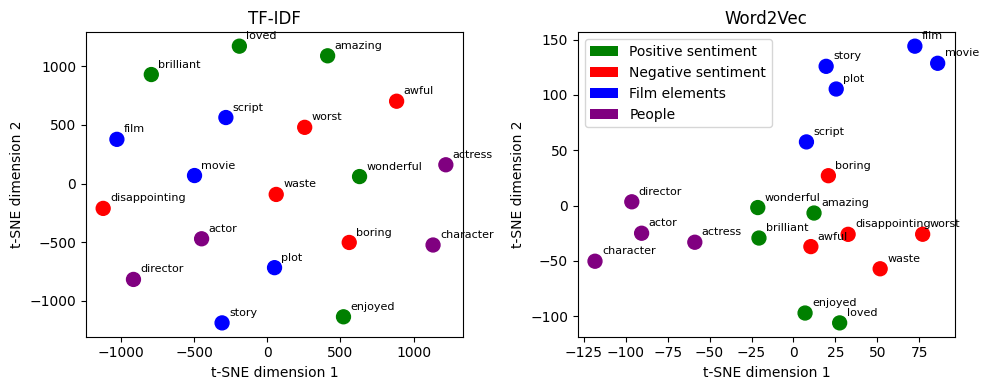

In [19]:
# Create color mapping by word category
colors = []

for word in words:
    if word in ['loved', 'enjoyed', 'brilliant', 'amazing', 'wonderful']:
        colors.append('green')

    elif word in ['boring', 'waste', 'disappointing', 'worst', 'awful']:
        colors.append('red')

    elif word in ['movie', 'film', 'story', 'plot', 'script']:
        colors.append('blue')

    else:
        colors.append('purple')

# Create 1x2 subplot
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# TF-IDF
axes[0].scatter(tfidf_2d[:, 0], tfidf_2d[:, 1], c=colors, s=100)

for i, word in enumerate(words):
    axes[0].annotate(
        word, (tfidf_2d[i, 0], tfidf_2d[i, 1]), 
        xytext=(5, 5), textcoords='offset points', fontsize=8
    )

axes[0].set_title('TF-IDF')
axes[0].set_xlabel('t-SNE dimension 1')
axes[0].set_ylabel('t-SNE dimension 2')

# Word2Vec
axes[1].scatter(w2v_2d[:, 0], w2v_2d[:, 1], c=colors, s=100)

for i, word in enumerate(words):
    axes[1].annotate(
        word, (w2v_2d[i, 0], w2v_2d[i, 1]), 
        xytext=(5, 5), textcoords='offset points', fontsize=8
)
    
axes[1].set_title('Word2Vec')
axes[1].set_xlabel('t-SNE dimension 1')
axes[1].set_ylabel('t-SNE dimension 2')

# Add legend
legend_elements = [
    Patch(facecolor='green', label='Positive sentiment'),
    Patch(facecolor='red', label='Negative sentiment'),
    Patch(facecolor='blue', label='Film elements'),
    Patch(facecolor='purple', label='People')
]

axes[1].legend(handles=legend_elements, loc='upper left')

plt.tight_layout()
plt.show()

**Interpreting the comparison:**

Each plot shows the same set of words projected into 2D space using t-SNE. The colors indicate semantic categories.

**Key observations:**

1. **TF-IDF** is a sparse, frequency-based encoding. Each word occupies an independent dimension in the original space with no inherent relationships. When projected to 2D, words appear scattered without meaningful clusters because TF-IDF doesn't capture semantic similarity.

2. **Word2Vec** captures semantic relationships in the original space, so semantically similar words cluster together even after dimension reduction. Positive sentiment words ("loved," "enjoyed,") group together, negative sentiment words cluster, film-related terms cluster, etc.

3. **Why this matters:** If you're building a system that needs to understand that "excellent" and "brilliant" mean similar things, or that "actor" and "director" are related concepts, Word2Vec provides that information naturally. TF-IDF treats these as completely independent features.

This visualization demonstrates the core advantage of dense embeddings: **semantic awareness**. While TF-IDF is computationally efficient and works well for many tasks, Word2Vec's ability to capture meaning makes it powerful for applications requiring semantic understanding.